#Download the Dataset directly from Kaggle using API

In [1]:
# For Google Colab
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"insert_username","key":"insert_key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d techsash/waste-classification-data

 97% 415M/427M [00:02<00:00, 212MB/s]
100% 427M/427M [00:02<00:00, 188MB/s]


In [3]:
# Unzip the data
import zipfile
with zipfile.ZipFile('/content/waste-classification-data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

The Dataset contains two classes:<br>
1. Organic (O) 
2. Recyclable (R)
<br>
Dataset is divided into train data (85%) and test data (15%)
<br>Training data - 22564 images Test data - 2513 images

<h3>Importing Libraries

In [4]:
import numpy as np 
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import seaborn as sns

In [5]:
# Path to the Dataset folder containing the classes
data_dir = '/content/DATASET/TRAIN'

In [7]:
# Our four classes:
classes = ['Organic', 'Recyclable']

In [6]:
# We use data generator by keras for loading the data into the format required by our model.
# Train validation split is set to 80, 20
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)
validation_generator = datagen.flow_from_directory(
    data_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb",
    class_mode="categorical")

train_generator = datagen.flow_from_directory(
    data_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical")

Found 22564 images belonging to 2 classes.
Found 18052 images belonging to 2 classes.


<h3> Model Architecture

In [8]:
# Defining the model architecture.
model = keras.models.Sequential([
    # Two sets of Convolution layers followed by an average pooling layers
    keras.layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu', input_shape=(256,256,3)),
    keras.layers.AveragePooling2D(),

    keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    keras.layers.AveragePooling2D(),

    keras.layers.Flatten(),

    # Two sets of Dropout layers followed by Dense layers, using RELU activation function
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation='relu'),

    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),

    # Softmax is used for multi-class classification
    keras.layers.Dense(units=2, activation = 'softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 average_pooling2d (AverageP  (None, 126, 126, 8)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 16)      3216      
                                                                 
 average_pooling2d_1 (Averag  (None, 61, 61, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                                 
 dropout (Dropout)           (None, 59536)             0

<h3> Model Training

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Setting model hyper-parameters
batch_size = 32
epochs = 15

# Compiling the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Training the model on the pre-processed dataset
history = model.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=validation_generator)

Epoch 1/15
565/565 [==============================] - 105s 166ms/step - loss: 0.4737 - accuracy: 0.8056 - val_loss: 0.3873 - val_accuracy: 0.8370
Epoch 2/15
565/565 [==============================] - 90s 159ms/step - loss: 0.3809 - accuracy: 0.8405 - val_loss: 0.3737 - val_accuracy: 0.8502
Epoch 3/15
565/565 [==============================] - 127s 224ms/step - loss: 0.3338 - accuracy: 0.8610 - val_loss: 0.3127 - val_accuracy: 0.8674
Epoch 4/15
565/565 [==============================] - 86s 152ms/step - loss: 0.2654 - accuracy: 0.8924 - val_loss: 0.2471 - val_accuracy: 0.9065
Epoch 5/15
565/565 [==============================] - 91s 160ms/step - loss: 0.1907 - accuracy: 0.9268 - val_loss: 0.2055 - val_accuracy: 0.9324
Epoch 6/15
565/565 [==============================] - 123s 217ms/step - loss: 0.1251 - accuracy: 0.9541 - val_loss: 0.1722 - val_accuracy: 0.9499
Epoch 7/15
565/565 [==============================] - 132s 235ms/step - loss: 0.0870 - accuracy: 0.9700 - val_loss: 0.1958 - va

<h3> Visualizing Metrics

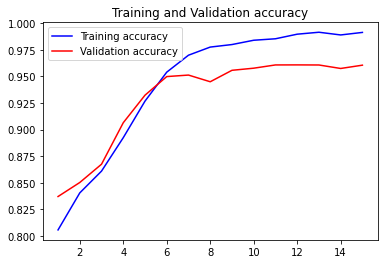

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.savefig('Training and Validation accuracy.png')

In [11]:
preds = model.predict_generator(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)

predicted_class_indices=np.argmax(pred,axis=1)

<ipython-input-11-cd0e3ff311e6>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(validation_generator, steps=5)


706/706 [==============================] - 49s 70ms/step


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     12905
           1       0.94      0.97      0.95      9659

    accuracy                           0.96     22564
   macro avg       0.96      0.96      0.96     22564
weighted avg       0.96      0.96      0.96     22564



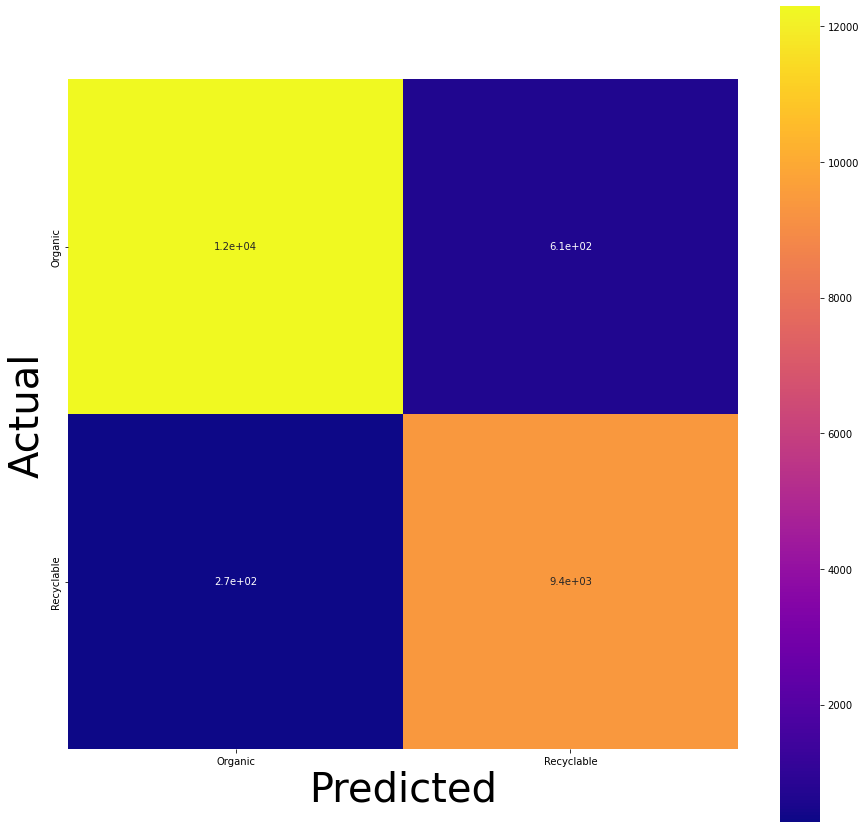

In [13]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cm, cmap=plt.cm.plasma, annot=True, square=True, xticklabels=classes, yticklabels=classes)

ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.savefig('heatmap.png')

##Get Accuracy on Unseen Data (Test Set)

In [39]:
def inference(path, show='True'):
  # Display the image
  if show:
    plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

  # Load image, preprocess and then predict using trained model
  image = tf.keras.preprocessing.image.load_img(path, target_size=(256,256,3))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])
  pred_class = model.predict(input_arr)
  class_idx = np.argmax(pred_class[0])

  return class_idx

1/1 [==============================] - 0s 20ms/step
Accuracy for Organic Class: 79.08636688079943%


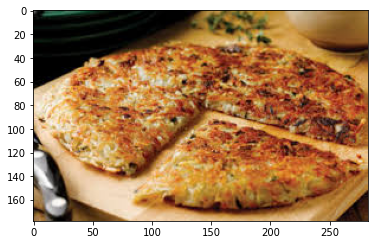

In [28]:
Organic_correct = 0
Organic_wrong = 0
folder = "/content/DATASET/TEST/O"
for filename in os.listdir(folder):
  pred = inference(os.path.join(folder,filename), False)
  if pred == 0:
    Organic_correct+=1
  else:
    Organic_wrong+=1

Organic_total = Organic_correct + Organic_wrong
print("Accuracy for Organic Class: " + str((Organic_correct/Organic_total)*100) + "%")

1/1 [==============================] - 0s 19ms/step
Accuracy for Recycle Class: 83.27338129496404%


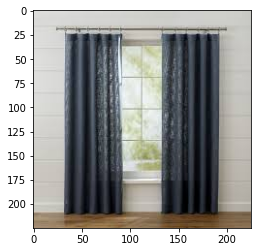

In [29]:
Recycle_correct = 0
Recycle_wrong = 0
folder = "/content/DATASET/TEST/R"
for filename in os.listdir(folder):
  pred = inference(os.path.join(folder,filename), False)
  if pred == 1:
    Recycle_correct+=1
  else:
    Recycle_wrong+=1

Recycle_total = Recycle_correct + Recycle_wrong
print("Accuracy for Recycle Class: " + str((Recycle_correct/Recycle_total)*100) + "%")

In [30]:
print("Overall accuracy on testset: " + str((Organic_correct+Recycle_correct)/(Organic_total+Recycle_total)) + "%")

Overall accuracy on testset: 0.8093911659371269%


<h3> Visualise Inference - Unseen Data (On Test Set)

In [22]:
import random

all_test = []
all_test_O = os.listdir("/content/DATASET/TEST/O")
all_test_O = ["/content/DATASET/TEST/O/" + x for x in all_test_O]

all_test_R = os.listdir("/content/DATASET/TEST/R")
all_test_R = ["/content/DATASET/TEST/R/" + x for x in all_test_R]

all_test = all_test_O + all_test_R

In [23]:
print(all_test)

['/content/DATASET/TEST/O/O_12636.jpg', '/content/DATASET/TEST/O/O_13301.jpg', '/content/DATASET/TEST/O/O_13548.jpg', '/content/DATASET/TEST/O/O_13943.jpg', '/content/DATASET/TEST/O/O_12628.jpg', '/content/DATASET/TEST/O/O_12604.jpg', '/content/DATASET/TEST/O/O_13890.jpg', '/content/DATASET/TEST/O/O_12689.jpg', '/content/DATASET/TEST/O/O_13141.jpg', '/content/DATASET/TEST/O/O_13120.jpg', '/content/DATASET/TEST/O/O_13743.jpg', '/content/DATASET/TEST/O/O_13913.jpg', '/content/DATASET/TEST/O/O_13392.jpg', '/content/DATASET/TEST/O/O_13923.jpg', '/content/DATASET/TEST/O/O_12837.jpg', '/content/DATASET/TEST/O/O_12845.jpg', '/content/DATASET/TEST/O/O_13323.jpg', '/content/DATASET/TEST/O/O_13826.jpg', '/content/DATASET/TEST/O/O_13206.jpg', '/content/DATASET/TEST/O/O_13750.jpg', '/content/DATASET/TEST/O/O_13014.jpg', '/content/DATASET/TEST/O/O_12663.jpg', '/content/DATASET/TEST/O/O_12919.jpg', '/content/DATASET/TEST/O/O_13088.jpg', '/content/DATASET/TEST/O/O_12578.jpg', '/content/DATASET/TEST/O

##Run this again for new Image

1/1 [==============================] - 0s 18ms/step
Predicted Class:  Organic


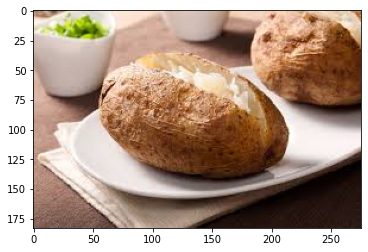

In [41]:
pred = inference(random.choice(all_test))
print("Predicted Class: ", classes[pred])

In [ ]:
# Connect to google drive and save model for later.
from google.colab import drive
drive.mount('/content/drive')

In [36]:
# Saving the model
model.save('/content/model.h5') 

<h3>Load and Predict

In [34]:
from keras.models import load_model

model_path = '/content/model.h5'
model = load_model(model_path)

def inference_load(path):
  # Display the image
  plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

  # Load image, preprocess and then predict using trained model
  image = tf.keras.preprocessing.image.load_img(path, target_size=(256,256,3))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])
  pred_class = model.predict(input_arr)
  class_idx = np.argmax(pred_class[0])

  print('Predicted Class = ', classes[class_idx])

1/1 [==============================] - 0s 22ms/step
Predicted Class =  Organic


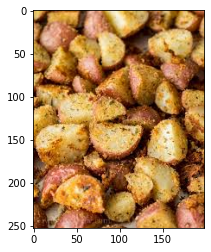

In [42]:
inference_load(random.choice(all_test))